In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ================================
# 🔌 Mount Google Drive
# ================================
from google.colab import drive
drive.mount('/content/drive')

# Define base path
base_path = "/content/drive/MyDrive/dataset/"


Mounted at /content/drive


In [ ]:
# ================================
# 📊 STEP 1: Clean Texas Load Data
# ================================
import pandas as pd
from datetime import timedelta

# Load all 3 CSVs
df_2018 = pd.read_csv(base_path + "texas2018.csv")
df_2019 = pd.read_csv(base_path + "texas2019.csv")
df_2020 = pd.read_csv(base_path + "texas2020.csv")

# Combine all
df_texas = pd.concat([df_2018, df_2019, df_2020], ignore_index=True)

# Clean HourEnding
df_texas['HourEnding'] = df_texas['HourEnding'].str.replace(" DST", "", regex=False)
df_texas['HourEnding'] = df_texas['HourEnding'].str.replace("24:00", "00:00", regex=False)
df_texas['HourEnding'] = pd.to_datetime(df_texas['HourEnding'], format="%m/%d/%Y %H:%M", errors='coerce')
df_texas['HourEnding'] += (df_texas['HourEnding'].dt.hour == 0) * timedelta(days=1)

# Convert demand values to float
demand_cols = df_texas.columns.drop("HourEnding")
for col in demand_cols:
    df_texas[col] = df_texas[col].str.replace(",", "", regex=False).astype(float)

# Rename datetime column
df_texas.rename(columns={"HourEnding": "datetime"}, inplace=True)

# Save cleaned file
df_texas.to_csv(base_path + "texas_cleaned.csv", index=False)
print("✅ Texas demand data cleaned and saved as 'texas_cleaned.csv'")


✅ Texas demand data cleaned and saved as 'texas_cleaned.csv'


In [ ]:
# ================================
# 🌦️ STEP 2: Combine Weather Data
# ================================
import json

# JSON weather files in your folder
weather_files = [
    "dallas.json", "houston.json", "la.json", "nyc.json", "philadelphia.json",
    "phoenix.json", "san_antonio.json", "san_diego.json", "san_jose.json", "seattle.json"
]

weather_dfs = []

# Load each JSON and process
for file in weather_files:
    file_path = base_path + file
    city = file.replace(".json", "")

    with open(file_path, "r") as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    df["city"] = city
    df["datetime"] = pd.to_datetime(df["time"], unit="s")  # fixed from 'dt' to 'time'
    weather_dfs.append(df)

# Combine all weather data
df_weather = pd.concat(weather_dfs, ignore_index=True)

# Save combined file
df_weather.to_csv(base_path + "weather_combined.csv", index=False)
print("✅ Weather data combined and saved as 'weather_combined.csv'")


✅ Weather data combined and saved as 'weather_combined.csv'


In [ ]:
# ================================
# 📚 Imports
# ================================
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ✅ Set your Drive base path
base_path = "/content/drive/MyDrive/dataset/"

# ================================
# 📥 Load Cleaned Datasets
# ================================
df_texas = pd.read_csv(base_path + "texas_cleaned.csv")
df_weather = pd.read_csv(base_path + "weather_combined.csv")

# ================================
# 🔄 Merge on datetime
# ================================
# Parse datetime columns
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_texas['datetime'] = pd.to_datetime(df_texas['datetime'])

# Round weather time to nearest hour to match demand
df_weather['datetime'] = df_weather['datetime'].dt.round('H')

# Merge weather and load data
merged_df = pd.merge(df_weather, df_texas, on='datetime', how='inner')

# ================================
# 🕒 Add Time Features
# ================================
merged_df['hour'] = merged_df['datetime'].dt.hour
merged_df['dayofweek'] = merged_df['datetime'].dt.dayofweek
merged_df['month'] = merged_df['datetime'].dt.month
merged_df['date'] = merged_df['datetime'].dt.date

# ================================
# 📊 Daily Aggregation (per city)
# ================================
daily_agg = merged_df.groupby(['city', 'date']).agg({
    'temperature': 'mean',
    'humidity': 'mean',
    'windSpeed': 'mean',
    'ERCOT': 'mean',
    'hour': 'mean',
    'dayofweek': 'first',
    'month': 'first'
}).reset_index()

# Rename columns
daily_agg.rename(columns={
    'temperature': 'temp',
    'humidity': 'humidity',
    'windSpeed': 'wind_speed',
    'ERCOT': 'demand'
}, inplace=True)

# ================================
# 📏 Normalize and PCA
# ================================
features = ['temp', 'humidity', 'wind_speed', 'demand', 'hour']
X = daily_agg[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (2 components)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

daily_agg['pca1'] = pca_result[:, 0]
daily_agg['pca2'] = pca_result[:, 1]

# ================================
# 💾 Save Outputs
# ================================
merged_df.to_csv(base_path + "merged_hourly_weather_demand.csv", index=False)
daily_agg.to_csv(base_path + "daily_aggregated_for_clustering.csv", index=False)

print("✅ DONE: Part 1 complete")
print("📁 Saved: merged_hourly_weather_demand.csv")
print("📁 Saved: daily_aggregated_for_clustering.csv (includes PCA)")


✅ DONE: Part 1 complete
📁 Saved: merged_hourly_weather_demand.csv
📁 Saved: daily_aggregated_for_clustering.csv (includes PCA)


📌 Dataset Shape: (6705, 11)

📌 Columns: ['city', 'date', 'temp', 'humidity', 'wind_speed', 'demand', 'hour', 'dayofweek', 'month', 'pca1', 'pca2']

📌 Sample Data:


,city,date,temp,humidity,wind_speed,demand,hour,dayofweek,month,pca1,pca2
0,dallas,2018-07-02,89.716316,0.512105,7.379474,57714.218421,14.0,0,7,2.836527,1.034262
1,dallas,2018-07-03,91.135833,0.449583,6.673750,55345.872917,11.5,1,7,2.652892,0.371389
2,dallas,2018-07-04,85.995000,0.566667,7.745417,47833.567917,11.5,2,7,1.464511,0.657443
3,dallas,2018-07-05,84.035833,0.617083,6.171667,49474.895417,11.5,3,7,1.576698,0.496410
4,dallas,2018-07-06,86.249167,0.603750,6.050833,50208.610833,11.5,4,7,1.775851,0.477871


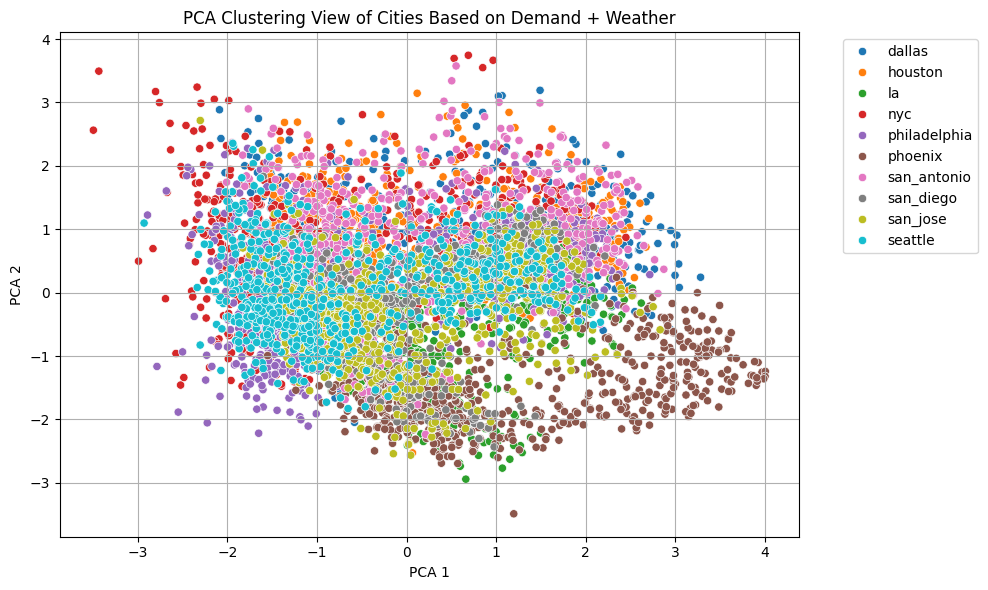

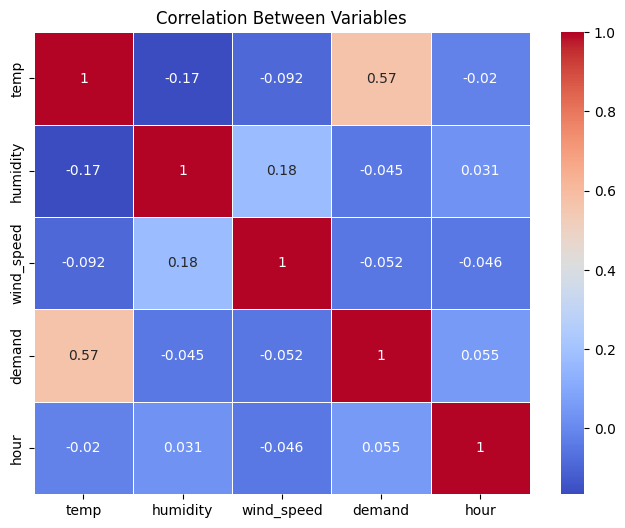

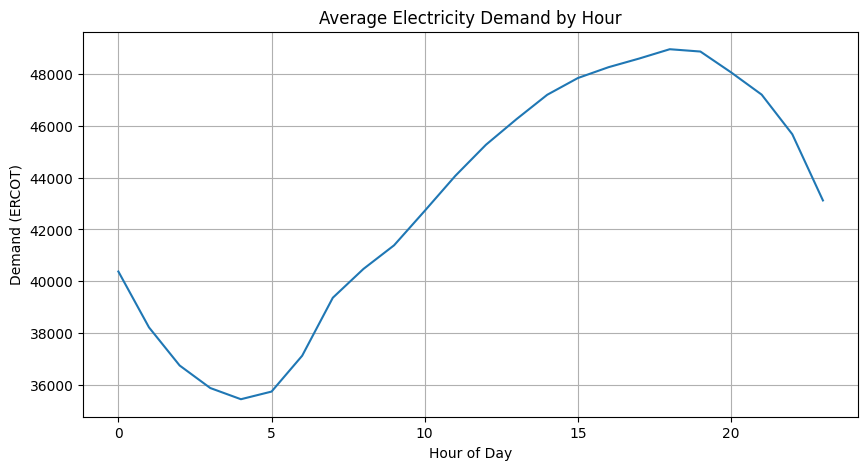

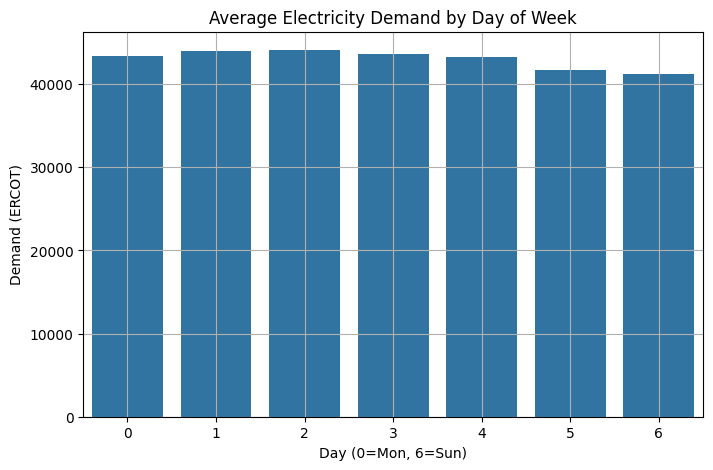

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your dataset
base_path = "/content/drive/MyDrive/dataset/"

# Load final daily PCA dataset
daily_agg = pd.read_csv(base_path + "daily_aggregated_for_clustering.csv")

# ================================
# ✅ 1. Dataset Summary
# ================================
print("📌 Dataset Shape:", daily_agg.shape)
print("\n📌 Columns:", daily_agg.columns.tolist())
print("\n📌 Sample Data:")
display(daily_agg.head())

# ================================
# 📈 2. PCA Scatter Plot (Clustering View)
# ================================
plt.figure(figsize=(10,6))
sns.scatterplot(data=daily_agg, x="pca1", y="pca2", hue="city", palette="tab10")
plt.title("PCA Clustering View of Cities Based on Demand + Weather")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ================================
# 🔥 3. Correlation Heatmap
# ================================
plt.figure(figsize=(8,6))
corr = daily_agg[['temp', 'humidity', 'wind_speed', 'demand', 'hour']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Variables")
plt.show()

# ================================
# 📊 4. Demand Trends by Hour & Day
# ================================
merged_df = pd.read_csv(base_path + "merged_hourly_weather_demand.csv")
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])
merged_df['hour'] = merged_df['datetime'].dt.hour
merged_df['dayofweek'] = merged_df['datetime'].dt.dayofweek

# Avg hourly demand
plt.figure(figsize=(10,5))
sns.lineplot(data=merged_df, x="hour", y="ERCOT", ci=None)
plt.title("Average Electricity Demand by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Demand (ERCOT)")
plt.grid(True)
plt.show()

# Avg daily demand
plt.figure(figsize=(8,5))
sns.barplot(data=merged_df, x="dayofweek", y="ERCOT", ci=None)
plt.title("Average Electricity Demand by Day of Week")
plt.xlabel("Day (0=Mon, 6=Sun)")
plt.ylabel("Demand (ERCOT)")
plt.grid(True)
plt.show()


In [ ]:
# ================================
# 📚 Imports
# ================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Load PCA dataset
base_path = "/content/drive/MyDrive/dataset/"
daily_agg = pd.read_csv(base_path + "daily_aggregated_for_clustering.csv")
X_pca = daily_agg[['pca1', 'pca2']]


🔹 KMeans Silhouette Score: 0.4003


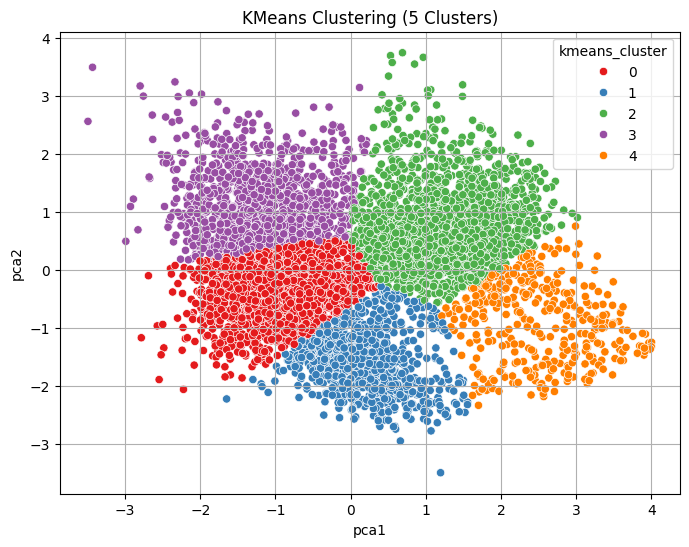

In [ ]:
# Apply KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
daily_agg['kmeans_cluster'] = kmeans.fit_predict(X_pca)

# Silhouette Score
kmeans_silhouette = silhouette_score(X_pca, daily_agg['kmeans_cluster'])
print(f"🔹 KMeans Silhouette Score: {kmeans_silhouette:.4f}")

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=daily_agg, x="pca1", y="pca2", hue="kmeans_cluster", palette="Set1")
plt.title("KMeans Clustering (5 Clusters)")
plt.grid(True)
plt.show()


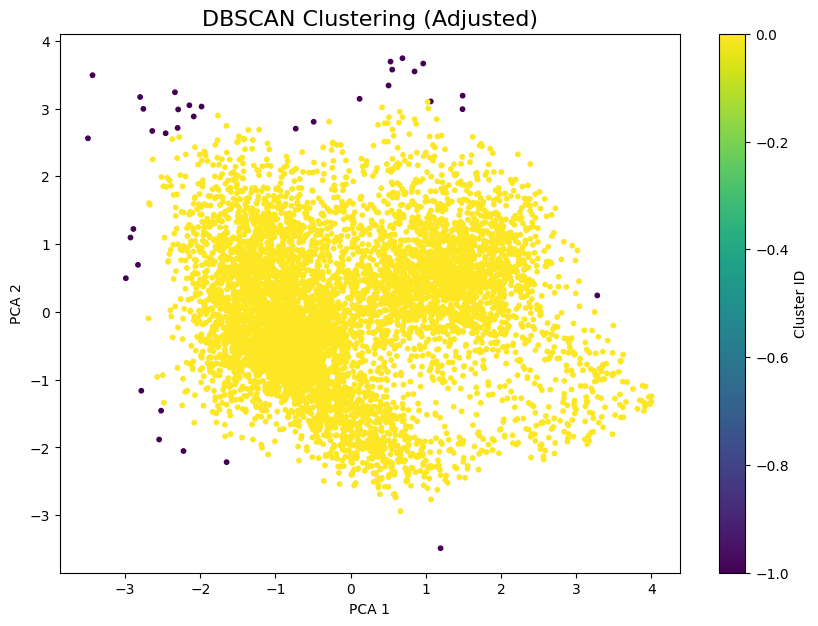

Number of DBSCAN clusters: 2


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Scale your data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(daily_agg[['pca1', 'pca2']])  # PCA columns

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=10)  # Try different eps and min_samples values
daily_agg['dbscan_cluster'] = dbscan.fit_predict(scaled_features)

# Plot DBSCAN clustering result
plt.figure(figsize=(10, 7))
plt.scatter(daily_agg['pca1'], daily_agg['pca2'], c=daily_agg['dbscan_cluster'], cmap='viridis', s=10)
plt.title('DBSCAN Clustering (Adjusted)', fontsize=16)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster ID')
plt.show()

# Check the number of clusters (excluding noise)
num_clusters = len(set(daily_agg['dbscan_cluster'])) - (1 if -1 in daily_agg['dbscan_cluster'] else 0)
print(f"Number of DBSCAN clusters: {num_clusters}")


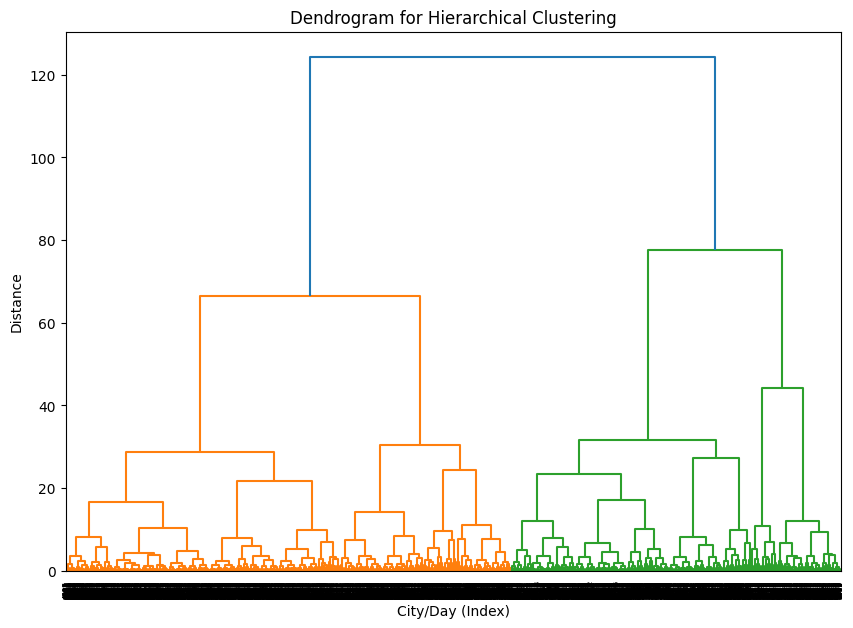

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
Z = linkage(daily_agg[['pca1', 'pca2']], 'ward')  # Ward linkage minimizes variance within clusters

# Create the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("City/Day (Index)")
plt.ylabel("Distance")
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(scaled_features, daily_agg['dbscan_cluster'])
print(f"Silhouette Score for DBSCAN: {sil_score:.4f}")


Silhouette Score for DBSCAN: 0.4458


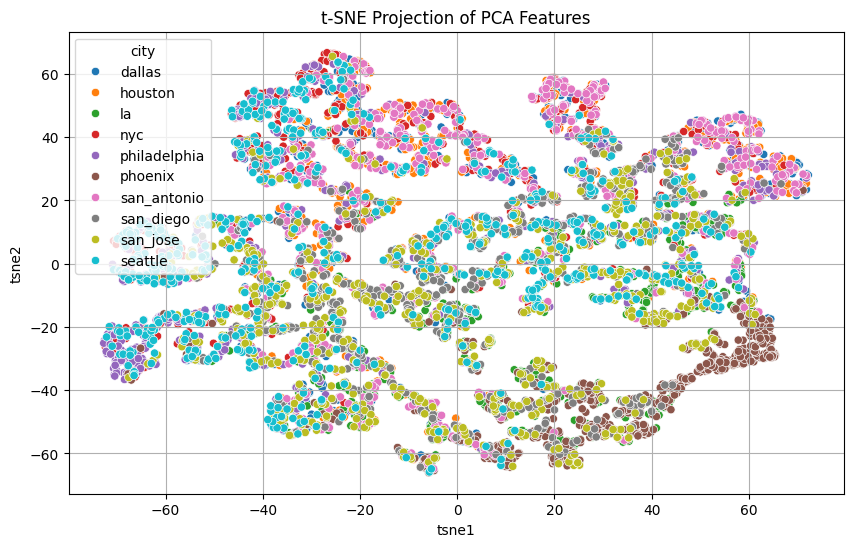

In [ ]:
# Run t-SNE
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_results = tsne.fit_transform(X_pca)

daily_agg['tsne1'] = tsne_results[:, 0]
daily_agg['tsne2'] = tsne_results[:, 1]

# Plot by city
plt.figure(figsize=(10,6))
sns.scatterplot(data=daily_agg, x="tsne1", y="tsne2", hue="city", palette="tab10")
plt.title("t-SNE Projection of PCA Features")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load final clustering dataset (from Part 2A)
df = pd.read_csv(base_path + "daily_aggregated_for_clustering.csv")

# Optional: Drop clustering labels if not needed for prediction
df = df.drop(columns=['pca1', 'pca2', 'kmeans_cluster'], errors='ignore')

# One-hot encode city column
df = pd.get_dummies(df, columns=['city'], drop_first=True)

# Features and target
features = df.drop(columns=['date', 'demand'])  # drop date + target
target = df['demand']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f"✅ Train samples: {X_train.shape[0]}  |  Test samples: {X_test.shape[0]}")


✅ Train samples: 5364  |  Test samples: 1341


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
}

results = {}
import numpy as np

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"RMSE": rmse, "R²": r2}
    print(f"📊 {name} → RMSE: {rmse:.2f}, R²: {r2:.4f}")


📊 Linear Regression → RMSE: 5336.45, R²: 0.4279
📊 Random Forest → RMSE: 3148.78, R²: 0.8008
📊 Gradient Boosting → RMSE: 3405.02, R²: 0.7671


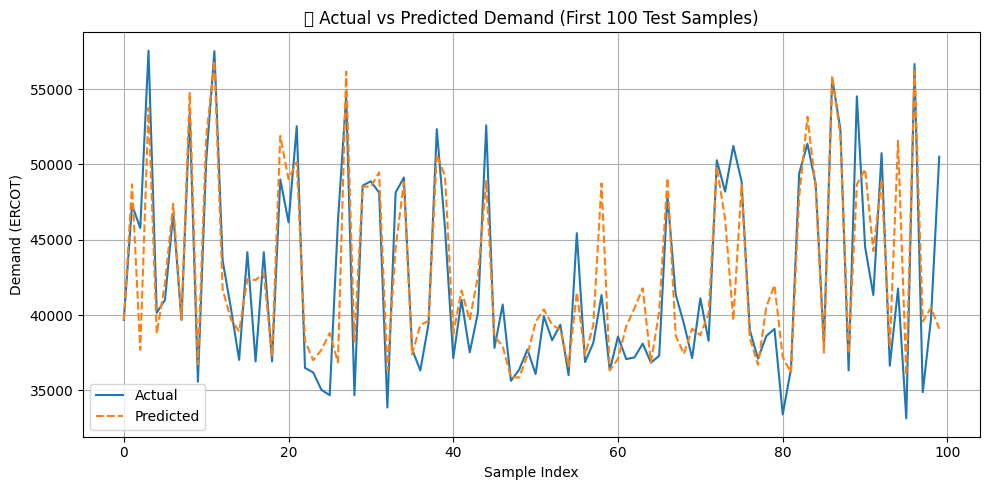

In [ ]:
import matplotlib.pyplot as plt

best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted', linestyle='dashed')
plt.title("🔍 Actual vs Predicted Demand (First 100 Test Samples)")
plt.ylabel("Demand (ERCOT)")
plt.xlabel("Sample Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install gradio --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.1 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import joblib
import pandas as pd
import numpy as np

# Load the trained model (replace with best model if saved)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)  # You can replace this with loading if model is saved

# City one-hot columns from your training set
city_columns = [col for col in X_train.columns if col.startswith('city_')]

# 📈 Prediction function
def predict_demand(temp, humidity, wind_speed, hour, dayofweek, month, city):
    # Create input DataFrame
    input_df = pd.DataFrame([{
        'temp': temp,
        'humidity': humidity,
        'wind_speed': wind_speed,
        'hour': hour,
        'dayofweek': dayofweek,
        'month': month,
        **{col: 1 if col == f'city_{city}' else 0 for col in city_columns}
    }])

    prediction = model.predict(input_df)[0]
    return f"📊 Predicted Electricity Demand: {prediction:.2f} MW"


In [ ]:
interface = gr.Interface(
    fn=predict_demand,
    inputs=[
        gr.Number(label="Temperature (°F)"),
        gr.Number(label="Humidity (0-1)"),
        gr.Number(label="Wind Speed (mph)"),
        gr.Slider(0, 23, step=1, label="Hour of Day"),
        gr.Slider(0, 6, step=1, label="Day of Week (0=Mon)"),
        gr.Slider(1, 12, step=1, label="Month"),
        gr.Dropdown(choices=[c.replace('city_', '') for c in city_columns], label="City")
    ],
    outputs=gr.Textbox(label="Demand Prediction"),
    title="⚡ Electricity Demand Forecasting",
    description="Enter weather and time data to forecast electricity demand."
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6416420f57791aebb8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
